<a href="https://colab.research.google.com/github/mhoangvslev/AI4DBCode-RTOS/blob/master/LLM4SchemaOrg_Experimental_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tiktoken matplotlib seaborn

In [ ]:
!wget https://zenodo.org/records/14391666/files/LLM4SchemaOrg.zip?download=1 -O LLM4SchemaOrg.zip
!unzip -o LLM4SchemaOrg.zip

In [57]:
import pandas as pd
import seaborn as sns
import numpy as np

In [58]:
#@title Assemble document related statistics (n_chunks, n_tokens)
#@markdown As you can see, 50% of documents fit in the windows context (having 1 chunk). Therefore it's safe to perform statistical tests of 1 chunk vs many chunks.
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd
from pathlib import Path
import math
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-") #cl100k_base, same with gpt-4


document_files = chain(
    glob("data/WDC/Pset/pset_length/stratum*/corpus/*.txt", recursive=True),
    glob("data/WDC/Pset/count_sum/stratum*/corpus/*.txt", recursive=True)
)

document_records = []
for document_file in document_files:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/([a-z0-9]{32})\.txt"
    m = re.search(patt, document_file)
    if m is None:
        print(document_file)

    document_text = Path(document_file).read_text()

    n_tokens = len(enc.encode(document_text))
    n_chunks = math.ceil(n_tokens/4096) # Overflow

    document_records.append({
        "sampling_feature": m.group(1),
        "stratum": m.group(2),
        "document_id": m.group(3),
        "n_tokens": n_tokens,
        "n_chunks": n_chunks
    })

document_df = pd.DataFrame.from_records(document_records)
document_df["n_chunks"].value_counts(normalize=True)

,proportion
n_chunks,
1,0.508197
2,0.251366
3,0.114754
4,0.054645
5,0.038251
6,0.010929
8,0.010929
17,0.005464
7,0.005464


In [59]:
stats_df = pd.read_parquet("data/WDC/Pset/stats.parquet")
stats_df.head(5)

,document_main_types,document_size_bytes,document_id,document_path,model,metric,document_sub_types,document_props,n_triples,score
0,[[Article]],20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,baseline,input,[[Article]],"[publisher, logo, url, name, datePublished, he...",11.0,NaN
1,[[Article]],20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt3,input,[[Article]],"[headline, author, datePublished, articleBody,...",6.0,NaN
2,[[Article]],20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt4,input,[[Article]],"[headline, author, name, datePublished, descri...",10.0,NaN
3,[[Article]],20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,baseline,shacl,[[Article]],"[publisher, logo, url, name, datePublished, he...",11.0,1.0
4,[[Article]],20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt3,shacl,[[Article]],"[headline, author, datePublished, articleBody,...",6.0,1.0


In [60]:
#@title Pre-processing
xp_df = pd.read_csv("data/WDC/Pset/results.csv")
xp_df = pd.merge(
    xp_df,
    stats_df[["document_id", "document_size_bytes"]].drop_duplicates(),
    on="document_id",
    suffixes=("", "_input")
)

xp_df = pd.merge(
    xp_df,
    document_df,
    on=["stratum", "document_id"]
)

def calc_rejection_rate(row):
    n_triples_input = xp_df[
        (xp_df["metric"] == "input") &
        (xp_df["approach"] == row["approach"]) &
        (xp_df["instance"] == row["instance"]) &
        (xp_df["sample_feature"] == row["sample_feature"]) &
        (xp_df["stratum"] == row["stratum"]) &
        (xp_df["document_classes"] == row["document_classes"]) &
        (xp_df["document_id"] == row["document_id"])
    ]["n_triples"].item()

    # print(n_triples_input)
    n_triples_output = row["n_triples"]
    return 1 - n_triples_output / n_triples_input

def rename_approach(row):
    if row["instance"] == "expected":
        return "Human"
    return row["approach"]

def rename_metric(x):
    if x == "semantic":
        return "compliance"
    elif x == "input":
        return "input"
    elif x == "factual":
        return "factuality"
    elif x == "jaccardms":
        return "mimr"
    elif x == "shacl":
        return "validity"
    else:
        return x

def rename_instance(x):
    if x == "pred":
        return "LLMs"
    elif x == "expected":
        return "Human"
    else:
        return x

xp_df["metric"] = xp_df["metric"].apply(rename_metric)
xp_df["instance"] = xp_df["instance"].apply(rename_instance)
xp_df["approach"] = xp_df.apply(rename_approach, axis=1)
xp_df["rejection_rate"] = xp_df.apply(calc_rejection_rate, axis=1)

xp_df

,metric,approach,instance,value,prompt_ver,n_triples,sample_feature,stratum,document_id,document_classes,document_size_bytes,sampling_feature,n_tokens,n_chunks,rejection_rate
0,compliance,GPT_4_Turbo_Preview,LLMs,1.000000,text2kg_prompt3,10.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,0.655172
1,compliance,GPT_4_Turbo_Preview,Human,1.000000,text2kg_prompt3,4.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,0.714286
2,input,GPT_4_Turbo_Preview,LLMs,0.000000,text2kg_prompt3,29.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,0.000000
3,input,GPT_4_Turbo_Preview,Human,0.000000,text2kg_prompt3,14.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,0.000000
4,mimr,GPT_4_Turbo_Preview,LLMs,1.000000,text2kg_prompt3,NaN,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,mimr,GPT_3_Turbo_16K,Human,0.830189,text2kg_prompt3,NaN,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,NaN
3956,compliance,GPT_3_Turbo_16K,LLMs,0.909091,text2kg_prompt3,10.0,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,0.333333
3957,compliance,GPT_3_Turbo_16K,Human,0.695652,text2kg_prompt3,15.0,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,0.594595
3958,mimr,GPT_3_Turbo_16K,LLMs,0.333333,text2kg_prompt3,NaN,count_sum,stratum_2,6f90084b4766a0b5e6ecbacb9dcd065d,DiscussionForumPosting,19297,count_sum,9824,3,NaN


# Human vs LLMs

## Document Size distribution

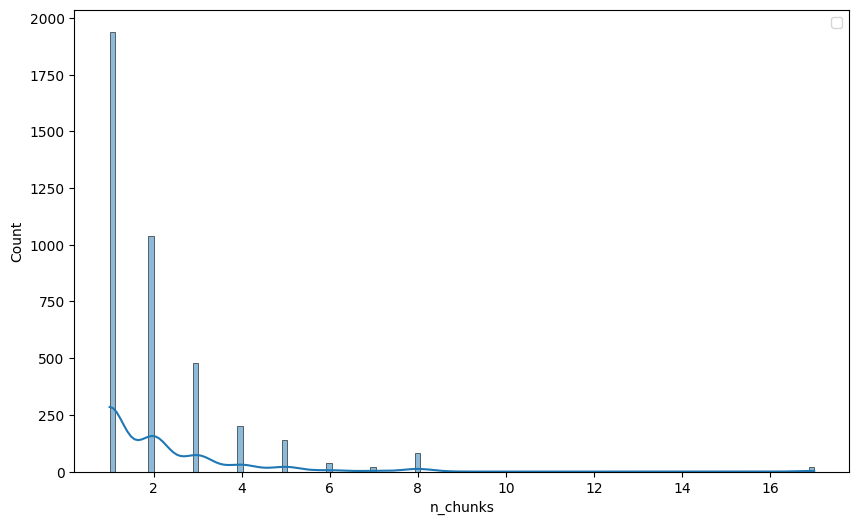

In [61]:
# prompt: Using seaborn, make a line plot with document_size on X-axis and semantic on Y-axis

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the necessary data loading and merging steps from the previous code are executed

# Create the line plot
plt.figure(figsize=(10, 6))
sns.histplot(data=xp_df, x="n_chunks", kde=True)

# Set labels and
plt.legend()
plt.show()

## Rejection Rate per Document Size

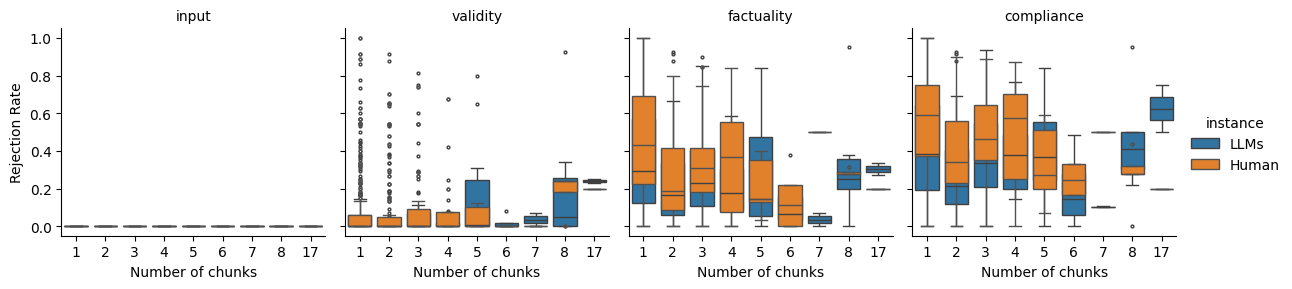

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['input', 'validity', 'factuality', 'compliance']

g = sns.FacetGrid(
    xp_df.query("`metric` in @cols"),
    col="metric",
    hue="instance",
    col_order=cols
)

def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(x=x, y=y, *args, **kwargs, boxprops={'label' : label})


g.map(fixed_boxplot, "n_chunks", "rejection_rate", fliersize=2)

g.set_axis_labels("Number of chunks", "Rejection Rate")
g.set_titles("{col_name}")
g.add_legend()
plt.show()

## MIMR per Document Size

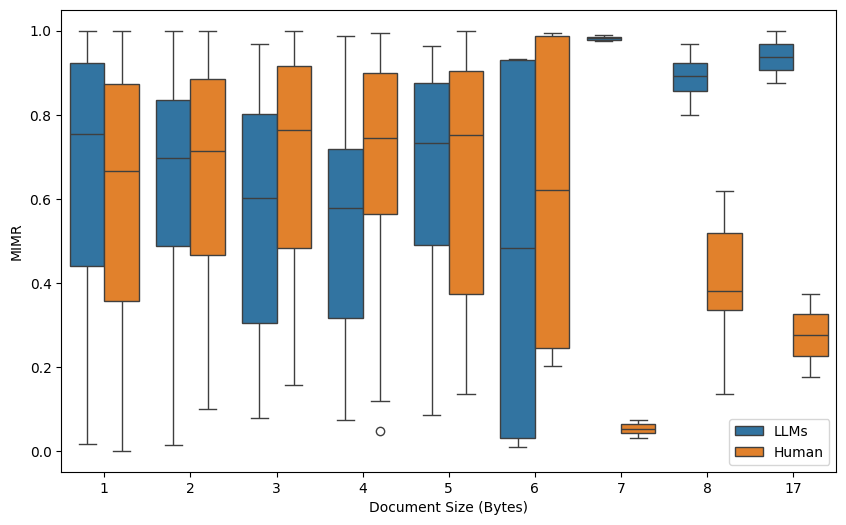

In [132]:
# prompt: Using seaborn, make a line plot with document_size on X-axis and semantic on Y-axis

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the necessary data loading and merging steps from the previous code are executed

# Create the line plot
plt.figure(figsize=(10, 6))
g = sns.boxplot(
    data=xp_df.query("`metric` == 'mimr'"),
    x="n_chunks", y="value", hue="instance",
)

# Set labels and
plt.xlabel("Document Size (Bytes)")
plt.ylabel("MIMR")
# plt.title("Human vs LLMs: MIMR")
plt.legend()
plt.show()

# How do LLMs and Human compare when Document Size increases?

In [133]:
xp_df["n_chunks_cat"] = xp_df["n_chunks"].apply(lambda x: "1" if x == 1 else "> 1")

In [148]:
from scipy.stats import ttest_ind

# Group data by document_size_cat
grouped = xp_df[xp_df["metric"] == "mimr"].groupby("n_chunks_cat")
one_chunk, many_chunks = [group["value"] for _, group in grouped]

t_statistic, p_value = ttest_ind(one_chunk, many_chunks, alternative="greater")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")
print("-" * 20)
if p_value < 0.05:
    print("There is a statistically significant degradation od MIMR when chunking")
else:
    print("There is no statistically significant degradation od MIMR when chunking")

T-statistic: 0.26192021562184087
P-value: 0.39672561492499436
--------------------
There is no statistically significant degradation od MIMR when chunking


## How do LLMs and Human compare when Document Size increases?

In [ ]:
result = xp_df.pivot_table(
    columns=["approach", "sample_feature", "stratum", "instance", "metric"],
    values=["value", "n_triples"],
    aggfunc={"n_triples": "sum", "value": "mean"}
).T
result

n_triples  \
approach            sample_feature stratum   instance metric                 
GPT_3_Turbo_16K     count_sum      stratum_0 expected factual        463.0   
                                                      input          910.0   
                                                      jaccardms        0.0   
                                                      semantic       402.0   
                                                      shacl          748.0   
...                                                                    ...   
GPT_4_Turbo_Preview pset_length    stratum_2 pred     factual        637.0   
                                                      input          938.0   
                                                      jaccardms        0.0   
                                                      semantic       572.0   
                                                      shacl          847.0   

                                                                    value  
approach            sample_feature stratum   instance metric               
GPT_3_Turbo_16K     count_sum      stratum_0 expected factual    0.708642  
                                                      input      0.000000  
                                                      jaccardms  0.602959  
                                                      semantic   0.896035  
                                                      shacl      0.948193  
...                                                                   ...  
GPT_4_Turbo_Preview pset_length    stratum_2 pred     factual    0.775310  
                                                      input      0.000000  
                                                      jaccardms  0.567492  
                                                      semantic   0.920952  
                                                      shacl      0.955724  

[120 rows x 2 columns]

In [ ]:
#@title Results per sampling feature (\#instance per c-set or \#properties per c-set) and per quantile (Low, Med, High)
result.query("sample_feature == 'pset_length' and stratum == 'stratum_2'")

n_triples  \
approach            sample_feature stratum   instance metric                 
GPT_3_Turbo_16K     pset_length    stratum_2 expected factual       1032.0   
                                                      input         1605.0   
                                                      jaccardms        0.0   
                                                      semantic       867.0   
                                                      shacl         1528.0   
                                             pred     factual        387.0   
                                                      input          545.0   
                                                      jaccardms        0.0   
                                                      semantic       366.0   
                                                      shacl          496.0   
GPT_4_Turbo_Preview pset_length    stratum_2 expected factual       1032.0   
                                                      input         1605.0   
                                                      jaccardms        0.0   
                                                      semantic       867.0   
                                                      shacl         1528.0   
                                             pred     factual        637.0   
                                                      input          938.0   
                                                      jaccardms        0.0   
                                                      semantic       572.0   
                                                      shacl          847.0   

                                                                    value  
approach            sample_feature stratum   instance metric               
GPT_3_Turbo_16K     pset_length    stratum_2 expected factual    0.678985  
                                                      input      0.000000  
                                                      jaccardms  0.772947  
                                                      semantic   0.864333  
                                                      shacl      0.958164  
                                             pred     factual    0.790187  
                                                      input      0.000000  
                                                      jaccardms  0.480739  
                                                      semantic   0.949276  
                                                      shacl      0.937136  
GPT_4_Turbo_Preview pset_length    stratum_2 expected factual    0.678985  
                                                      input      0.000000  
                                                      jaccardms  0.704814  
                                                      semantic   0.864333  
                                                      shacl      0.958164  
                                             pred     factual    0.775310  
                                                      input      0.000000  
                                                      jaccardms  0.567492  
                                                      semantic   0.920952  
                                                      shacl      0.955724

# Factuality Checker: results breakdown

In [ ]:
#@title Assemble results
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd

factuality_reports = chain(
    glob("data/WDC/Pset/**/**factual_pred.json", recursive=True),
    glob("data/WDC/Pset/**/**factual_expected.json", recursive=True)
)

factuality_records = []
for factuality_report in factuality_reports:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/(\w+)(/(text2kg_prompt3))?/([a-z0-9]{32})_(\w+)_factual_(pred|expected)\.json"
    m = re.search(patt, factuality_report)
    if m is None:
        print(factuality_report)

    report_data = srsly.read_json(factuality_report)

    for chunk_name, chunk in report_data.items():
        for query in chunk.keys():
            if query in ["status", "score"]:
                continue

            if chunk_name == "aggregation":
                continue

            prop, value, parent = query.split("[TOK_Q_DELIM]")
            response = chunk[query]["response"]
            if response == "TOKPOS":
                response = "positive"
            elif response == "TOKNEG":
                response = "negative"

            factuality_records.append({
                "sampling_feature": m.group(1),
                "stratum": m.group(2),
                "model": m.group(3),
                "prompt": m.group(5),
                "document_id": m.group(6),
                "document_classes": m.group(7).split("_"),
                "instance": m.group(8),
                "property": prop,
                "response": response,
                "value": value,
                "parent": parent,
            })

factuality_df = pd.DataFrame.from_records(factuality_records)
factuality_df

,sampling_feature,stratum,model,prompt,document_id,document_classes,instance,property,response,value,parent
0,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,9a0f1135eb0d40f064faeff4d072e41c,[NewsArticle],pred,image,positive,https://dimages2.gazzettaobjects.it/files/imag...,NewsArticle
1,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,9a0f1135eb0d40f064faeff4d072e41c,[NewsArticle],pred,description,positive,Analisi delle possibilità dei contendenti al t...,NewsArticle
2,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,9a0f1135eb0d40f064faeff4d072e41c,[NewsArticle],pred,name,positive,Massimo Brizzi,Person
3,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,9a0f1135eb0d40f064faeff4d072e41c,[NewsArticle],pred,name,positive,Gazzetta,Organization
4,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,9a0f1135eb0d40f064faeff4d072e41c,[NewsArticle],pred,articleBody,positive,Con 125 punti a disposizione vediamo il borsin...,NewsArticle
...,...,...,...,...,...,...,...,...,...,...,...
20179,pset_length,stratum_0,baseline,None,95295d10e7795e253b5e601554ae1daa,[FoodEstablishment],expected,dayOfWeek,positive,,OpeningHoursSpecification
20180,pset_length,stratum_0,baseline,None,95295d10e7795e253b5e601554ae1daa,[FoodEstablishment],expected,opens,positive,,OpeningHoursSpecification
20181,pset_length,stratum_0,baseline,None,95295d10e7795e253b5e601554ae1daa,[FoodEstablishment],expected,closes,positive,,OpeningHoursSpecification
20182,pset_length,stratum_0,baseline,None,95295d10e7795e253b5e601554ae1daa,[FoodEstablishment],expected,width,positive,1500,ImageObject


In [ ]:
#@title Top 10 properties per label (positive/negative)

from collections import Counter

def filter_common_elements(row, topk=10):
    factual = row.xs("positive", level="response")
    non_factual = row.xs("negative", level="response")

    new_factuals = []
    new_non_factuals = []

    for f, nf in zip(factual, non_factual):
        f_keys = set(f.keys()) - set(nf.keys())
        nf_keys = set(nf.keys()) - set(f.keys())
        new_f = Counter({ k: v for k, v in f.items() if k in f_keys })
        new_nf = Counter({ k: v for k, v in nf.items() if k in nf_keys })
        new_factuals.append(new_f)
        new_non_factuals.append(new_nf)

    # row.loc[(slice(None), 'factual')] = new_factuals
    # row.loc[(slice(None), 'factual')] = new_non_factuals
    # return row

    # Assign the new values back to the row
    for idx in row.index:
        if idx[1] == 'positive':
            row[idx] = new_factuals.pop(0)
        elif idx[1] == 'negative':
            row[idx] = new_non_factuals.pop(0)
    return row

result_df = (
    factuality_df
        .pivot_table(
            columns=["model", "response"],
            values=["property"],
            aggfunc={
                "property": Counter,
            }
        )
    #.apply(filter_common_elements, axis=1)
    .apply(lambda x: pd.Series(x.item().most_common(10)))
    # .apply(lambda x: pd.Series([v for v in x.item().values()]))
    # .sum()
)

(
    result_df
    .loc[:, result_df.columns.get_level_values('response') == 'negative']
)

model,GPT_3_Turbo_16K,GPT_4_Turbo_Preview,baseline
response,negative,negative,negative
0,"(name, 342)","(sameAs, 209)","(name, 403)"
1,"(url, 118)","(name, 203)","(sameAs, 321)"
2,"(datePublished, 85)","(datePublished, 90)","(url, 153)"
3,"(position, 48)","(url, 90)","(datePublished, 83)"
4,"(sameAs, 39)","(image, 87)","(email, 36)"
5,"(image, 35)","(telephone, 67)","(telephone, 35)"
6,"(dayOfWeek, 25)","(email, 51)","(additionalType, 33)"
7,"(email, 23)","(isBasedOnUrl, 47)","(height, 32)"
8,"(telephone, 18)","(significantLink, 47)","(dateModified, 30)"


# Compliance Checker: results breakdown

In [ ]:
#@title Assemble results
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd

compliance_reports = chain(
    glob("data/WDC/Pset/**/**semantic_pred.json", recursive=True),
    glob("data/WDC/Pset/**/**semantic_expected.json", recursive=True)
)

compliance_records = []
for compliance_report in compliance_reports:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/(\w+)(/(text2kg_prompt3))?/([a-z0-9]{32})_(\w+)_semantic_(pred|expected)\.json"
    m = re.search(patt, compliance_report)
    if m is None:
        print(compliance_report)

    report_data = srsly.read_json(compliance_report)

    for chunk_name, chunk in report_data.items():
        for query in chunk.keys():
            if query in ["status", "score"]:
                continue

            if chunk_name == "aggregation":
                continue

            prop, value, parent = query.split("[TOK_Q_DELIM]")
            response = chunk[query]["response"]
            if response == "TOKPOS":
                response = "positive"
            elif response == "TOKNEG":
                response = "negative"

            compliance_records.append({
                "sampling_feature": m.group(1),
                "stratum": m.group(2),
                "model": m.group(3),
                "prompt": m.group(5),
                "document_id": m.group(6),
                "document_classes": m.group(7).split("_"),
                "instance": m.group(8),
                "property": prop,
                "response": response,
                "value": value,
                "parent": parent,
            })

compliance_df = pd.DataFrame.from_records(compliance_records)
compliance_df

,sampling_feature,stratum,model,prompt,document_id,document_classes,instance,property,response,value,parent
0,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,cdf79e281eb25924b435ed9f7f4d250f,[NewsArticle],pred,image,positive,https://assets2.cbsnewsstatic.com/hub/i/r/2019...,NewsArticle
1,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,cdf79e281eb25924b435ed9f7f4d250f,[NewsArticle],pred,image,positive,https://assets1.cbsnewsstatic.com/hub/i/r/2019...,NewsArticle
2,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,cdf79e281eb25924b435ed9f7f4d250f,[NewsArticle],pred,image,positive,https://assets3.cbsnewsstatic.com/hub/i/r/2019...,NewsArticle
3,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,cdf79e281eb25924b435ed9f7f4d250f,[NewsArticle],pred,image,positive,https://assets1.cbsnewsstatic.com/hub/i/r/2019...,NewsArticle
4,count_sum,stratum_1,GPT_4_Turbo_Preview,text2kg_prompt3,cdf79e281eb25924b435ed9f7f4d250f,[NewsArticle],pred,image,positive,https://assets3.cbsnewsstatic.com/hub/i/r/2019...,NewsArticle
...,...,...,...,...,...,...,...,...,...,...,...
9604,pset_length,stratum_0,baseline,None,c571136499f0bd2479119e8a6da09581,[Review],expected,reviewBody,positive,A verdade que muito feliz com a compra. Estou ...,Review
9605,pset_length,stratum_0,baseline,None,c571136499f0bd2479119e8a6da09581,[Review],expected,reviewBody,positive,Telefone tremendo para o que custa. O AI da câ...,Review
9606,pset_length,stratum_0,baseline,None,c571136499f0bd2479119e8a6da09581,[Review],expected,reviewBody,positive,"Eu fui de um huawei p8 lite para esta honra, e...",Review
9607,pset_length,stratum_0,baseline,None,c571136499f0bd2479119e8a6da09581,[Review],expected,reviewBody,positive,terminal fantástico para o momento. A única co...,Review


In [ ]:
#@title Top 10 properties per label (positive/negative)

from collections import Counter

def filter_common_elements(row, topk=10):
    factual = row.xs("positive", level="response")
    non_factual = row.xs("negative", level="response")

    new_factuals = []
    new_non_factuals = []

    for f, nf in zip(factual, non_factual):
        f_keys = set(f.keys()) - set(nf.keys())
        nf_keys = set(nf.keys()) - set(f.keys())
        new_f = Counter({ k: v for k, v in f.items() if k in f_keys })
        new_nf = Counter({ k: v for k, v in nf.items() if k in nf_keys })
        new_factuals.append(new_f)
        new_non_factuals.append(new_nf)

    # row.loc[(slice(None), 'factual')] = new_factuals
    # row.loc[(slice(None), 'factual')] = new_non_factuals
    # return row

    # Assign the new values back to the row
    for idx in row.index:
        if idx[1] == 'positive':
            row[idx] = new_factuals.pop(0)
        elif idx[1] == 'negative':
            row[idx] = new_non_factuals.pop(0)
    return row

result_df = (
    compliance_df
        .pivot_table(
            columns=["model", "response"],
            values=["property"],
            aggfunc={
                "property": Counter,
            }
        )
    #.apply(filter_common_elements, axis=1)
    .apply(lambda x: pd.Series(x.item().most_common(10)))
    # .apply(lambda x: pd.Series([v for v in x.item().values()]))
    # .sum()
)

(
    result_df
    .loc[:, result_df.columns.get_level_values('response') == 'negative']
)

model,GPT_3_Turbo_16K,GPT_4_Turbo_Preview,baseline
response,negative,negative,negative
0,"(position, 224)","(significantLink, 59)","(keywords, 36)"
1,"(text, 21)","(streetAddress, 26)","(hasPart, 35)"
2,"(name, 16)","(value, 24)","(url, 34)"
3,"(contentUrl, 15)","(jobTitle, 22)","(price, 34)"
4,"(keywords, 11)","(keywords, 20)","(knowsAbout, 27)"
5,"(recipeIngredient, 9)","(recipeIngredient, 18)","(openingHours, 22)"
6,"(addressCountry, 8)","(sameAs, 17)","(position, 17)"
7,"(value, 7)","(serviceArea, 15)","(name, 14)"
8,"(urlTemplate, 6)","(image, 14)","(sameAs, 14)"


# Human evaluation

In [ ]:
!wget https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt3.csv -O ab_gpt3.csv
!wget https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt4.csv -O ab_gpt4.csv

--2024-06-05 13:31:51--  https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt3.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GDD-Nantes/MarkupGeneratorABTest/main/ab_gpt3.csv [following]
--2024-06-05 13:31:51--  https://raw.githubusercontent.com/GDD-Nantes/MarkupGeneratorABTest/main/ab_gpt3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4407 (4.3K) [text/plain]
Saving to: ‘ab_gpt3.csv’

ab_gpt3.csv         100%[===================>]   4.30K  --.-KB/s    in 0s      

2024-06-05 13:31:51 (45.3 MB/s) - ‘ab_gpt3.csv’ saved [4407/4407]

--2024-06-05 13:31:51--  https://githu

In [ ]:
import re
from collections import Counter
import pandas as pd

ab_v3_df = pd.read_csv("ab_gpt3.csv")
ab_v4_df = pd.read_csv("ab_gpt4.csv")

ab_v3_df["instance"] = "gpt3"
ab_v4_df["instance"] = "gpt4"

ab_df = (
    pd.concat([ab_v3_df, ab_v4_df])
    .drop(["Timestamp", "Score"], axis=1)
    .replace("They are tied (They are all good or all bad)", "Tie")
)
ab_df.columns = [re.search(r"([a-z0-9]+):", c).group(1) if c != "instance" else "instance" for c in ab_df.columns]
ab_df = ab_df.pivot_table(columns="instance", aggfunc=Counter)
ab_df

instance,gpt3,gpt4
0aab606677703ad0eaa5112790b22eec,{'Markup B': 6},{'Markup B': 7}
1bce98c5308e236f65e62a59ff815433,"{'Markup A': 4, 'Markup B': 2}","{'Markup A': 2, 'Tie': 5}"
21a447da550c501812e5f3148cd3b223,"{'Markup B': 5, 'Tie': 1}","{'Tie': 4, 'Markup B': 2, 'Markup A': 1}"
2e92108eeef6af0c24a5637f12ce7264,"{'Markup B': 4, 'Markup A': 2}","{'Markup A': 4, 'Tie': 2, 'Markup B': 1}"
345759b16a979ca20c5e22ef78c9c3a4,{'Markup A': 6},"{'Markup B': 6, 'Tie': 1}"
43abb6a0ee1c114a7923f56ef5e9df0c,{'Markup A': 6},"{'Markup B': 2, 'Tie': 3, 'Markup A': 2}"
5acb13a6d1776ceab442df15ac28488a,"{'Markup A': 3, 'Markup B': 1, 'Tie': 2}","{'Markup B': 6, 'Markup A': 1}"
5c3628c2e1553541b0ad4597d4a52170,{'Markup A': 6},"{'Markup B': 5, 'Tie': 1, 'Markup A': 1}"
690a9803a4ff14a368e32559f16ba3c9,"{'Markup A': 4, 'Tie': 2}","{'Markup A': 5, 'Tie': 2}"
6b394ce342a0bc94b4ec91654b175de4,"{'Markup A': 5, 'Markup B': 1}","{'Tie': 2, 'Markup A': 5}"


In [ ]:
from scipy import stats

def assign_score(x):
    score = {
        "Markup A": 0,
        "Markup B": 0,
    }

    for response, count in x.items():
        if response == "Tie":
            score["Markup A"] += count
            score["Markup B"] += count
        else:
            score[response] += count

    return score

def expand_counter(row):
    for response, count in row["counter"].items():
        row[response] = count
    return row

def assign_and_expand(x):
    tmp = (x
        .apply(assign_score).to_frame("counter")
        .apply(expand_counter, axis=1)
        .drop("counter", axis=1)
    )
    tmp["instance"] = x.name
    return tmp

def ttest(x):
    tscore, pvalue = stats.ttest_rel(*x.tolist(), alternative="less")
    return f"({tscore}, {pvalue})"

def assign_winner(x):
    _, max_count = x.most_common(1)[0]
    max_items = [ k for k, v in x.items() if v == max_count ]
    # If there is a clear winner
    if len(max_items) == 1:
        return max_items[0]
    return "Tie"

# tmp = pd.concat(
#     ab_df.apply(assign_and_expand, result_type="reduce").values
# )

# tmp_sum = tmp.pivot_table(columns="instance", aggfunc="sum")
# tmp_list = tmp.pivot_table(columns="instance", aggfunc=list)
# tmp_ttest = tmp_list.apply(ttest)
# tmp_ttest.name = "t-test()"

# result_df = tmp_sum.div(tmp_sum.sum(axis=0), axis=1)
# result_df.loc[len(result_df.index)] = tmp_ttest
# result_df

ab_per_doc = ab_df.apply(lambda x: x.apply(assign_winner))
ab_per_doc

instance,gpt3,gpt4
0aab606677703ad0eaa5112790b22eec,Markup B,Markup B
1bce98c5308e236f65e62a59ff815433,Markup A,Tie
21a447da550c501812e5f3148cd3b223,Markup B,Tie
2e92108eeef6af0c24a5637f12ce7264,Markup B,Markup A
345759b16a979ca20c5e22ef78c9c3a4,Markup A,Markup B
43abb6a0ee1c114a7923f56ef5e9df0c,Markup A,Tie
5acb13a6d1776ceab442df15ac28488a,Markup A,Markup B
5c3628c2e1553541b0ad4597d4a52170,Markup A,Markup B
690a9803a4ff14a368e32559f16ba3c9,Markup A,Markup A
6b394ce342a0bc94b4ec91654b175de4,Markup A,Markup A


In [ ]:
mimir = xp_df.pivot_table(index="document_id", columns=["approach", "instance", "metric"], values="value", aggfunc="mean")
mimir

approach                         GPT_3_Turbo_16K                      \
instance                                expected                       
metric                                   factual jaccardms  semantic   
document_id                                                            
00452a06e9cc4f50088ba755ac4200c3        0.625000  0.857143  1.000000   
010fe200abe39e41b44cc685ea3daaaf        1.000000  0.875000  0.800000   
01960fe2283a00855e55b86932ef56a0        0.653846  0.846154  0.882353   
02f415c4c32d5448a47810e8a1ca3c78        0.666667  0.031579  1.000000   
03bc1aedb07a529cdac7b7d9db6ac56b        0.600000  0.571429  0.600000   
...                                          ...       ...       ...   
fdc0c0d51e6df46f36843dc071f2f04f             NaN  0.731544       NaN   
fe64a80e4a7976d977d4c0c1894d27cd        1.000000  0.166667  1.000000   
ff54b11443138f583d50d2ebb03c0936        0.933333  0.690476  0.916667   
ffaa62434d1aa95419b80992efc8f22f        0.500000  0.678571  0.600000   
ffc6598961ef48ac12d1d3131a6fca4f        0.714286  0.833333  0.700000   

approach                                                                  \
instance                                        pred                       
metric                               shacl   factual jaccardms  semantic   
document_id                                                                
00452a06e9cc4f50088ba755ac4200c3  1.000000  0.666667  0.428571  1.000000   
010fe200abe39e41b44cc685ea3daaaf  1.000000  0.666667  0.500000  1.000000   
01960fe2283a00855e55b86932ef56a0  0.962963  0.818182  0.615385  1.000000   
02f415c4c32d5448a47810e8a1ca3c78  1.000000  1.000000  0.989474  0.962264   
03bc1aedb07a529cdac7b7d9db6ac56b  1.000000  0.800000  0.571429  0.750000   
...                                    ...       ...       ...       ...   
fdc0c0d51e6df46f36843dc071f2f04f  0.485714  0.825397  0.704698  0.730769   
fe64a80e4a7976d977d4c0c1894d27cd  1.000000  1.000000  1.000000  1.000000   
ff54b11443138f583d50d2ebb03c0936  1.000000  1.000000  0.488624  0.969697   
ffaa62434d1aa95419b80992efc8f22f  1.000000  0.461538  0.571429  1.000000   
ffc6598961ef48ac12d1d3131a6fca4f  0.937500  0.714286  0.500000  0.600000   

approach                                   GPT_4_Turbo_Preview            \
instance                                              expected             
metric                               shacl             factual jaccardms   
document_id                                                                
00452a06e9cc4f50088ba755ac4200c3  1.000000            0.625000  0.352941   
010fe200abe39e41b44cc685ea3daaaf  1.000000            1.000000  0.583333   
01960fe2283a00855e55b86932ef56a0  1.000000            0.653846  0.293333   
02f415c4c32d5448a47810e8a1ca3c78  0.929825            0.666667  0.075000   
03bc1aedb07a529cdac7b7d9db6ac56b  1.000000            0.600000  0.047619   
...                                    ...                 ...       ...   
fdc0c0d51e6df46f36843dc071f2f04f  1.000000                 NaN  0.865079   
fe64a80e4a7976d977d4c0c1894d27cd  1.000000            1.000000  0.105263   
ff54b11443138f583d50d2ebb03c0936  0.698413            0.933333  0.377342   
ffaa62434d1aa95419b80992efc8f22f  0.673469            0.500000  0.760000   
ffc6598961ef48ac12d1d3131a6fca4f  1.000000            0.714286  0.135135   

approach                                                                  \
instance                                                  pred             
metric                            semantic     shacl   factual jaccardms   
document_id                                                                
00452a06e9cc4f50088ba755ac4200c3  1.000000  1.000000  0.888889  0.941176   
010fe200abe39e41b44cc685ea3daaaf  0.800000  1.000000  0.928571  0.958333   
01960fe2283a00855e55b86932ef56a0  0.882353  0.962963  0.756757  0.920000   
02f415c4c32d5448a47810e8a1ca3c78  1.000000  1.000000  1.000000  0.975000   
03bc1aedb07a529cdac7b7d9db6ac

In [ ]:
def assign_label(row):
    return "Markup A" if row[0].item() > row[1].item() else "Markup B" if row[0].item() < row[1].item() else "Tie"

def assign_mimir_winner(row):
    expected_jaccardms = row.xs('jaccardms', level='metric').xs('expected', level='instance')
    predicted_jaccardms = row.xs('jaccardms', level='metric').xs('pred', level='instance')
    labels = expected_jaccardms.compare(predicted_jaccardms, keep_shape=True, keep_equal=True)
    return labels.apply(assign_label, axis=1)

mimir_per_doc = mimir.apply(assign_mimir_winner, axis=1)
mimir_per_doc

approach,GPT_3_Turbo_16K,GPT_4_Turbo_Preview
document_id,,
00452a06e9cc4f50088ba755ac4200c3,Markup A,Markup B
010fe200abe39e41b44cc685ea3daaaf,Markup A,Markup B
01960fe2283a00855e55b86932ef56a0,Markup A,Markup B
02f415c4c32d5448a47810e8a1ca3c78,Markup B,Markup B
03bc1aedb07a529cdac7b7d9db6ac56b,Tie,Markup B
...,...,...
fdc0c0d51e6df46f36843dc071f2f04f,Markup A,Markup A
fe64a80e4a7976d977d4c0c1894d27cd,Markup B,Markup B
ff54b11443138f583d50d2ebb03c0936,Markup A,Markup B


In [ ]:
final_ab_raw = (
    ab_per_doc
    .join(mimir_per_doc, how="inner")
    .rename(columns={
        "gpt3": "gpt3-h",
        "GPT_3_Turbo_16K": "gpt3-m",
        "gpt4": "gpt4-h",
        "GPT_4_Turbo_Preview": "gpt4-m"
    })
    .reindex(columns=["gpt3-h", "gpt3-m", "gpt4-h", "gpt4-m"])
    .reset_index(names="document_id")

)
final_ab_raw["document_id"] = final_ab_raw["document_id"].apply(lambda x: x[:5] + "...")
final_ab_raw

,document_id,gpt3-h,gpt3-m,gpt4-h,gpt4-m
0,0aab6...,Markup B,Markup B,Markup B,Markup B
1,1bce9...,Markup A,Markup B,Tie,Markup B
2,21a44...,Markup B,Markup B,Tie,Tie
3,2e921...,Markup B,Markup B,Markup A,Markup B
4,34575...,Markup A,Markup A,Markup B,Markup B
5,43abb...,Markup A,Markup A,Tie,Markup A
6,5acb1...,Markup A,Markup A,Markup B,Markup B
7,5c362...,Markup A,Markup A,Markup B,Markup B
8,690a9...,Markup A,Markup A,Markup A,Markup A
9,6b394...,Markup A,Markup A,Markup A,Markup A


In [ ]:
def assign(row):
    """When one of the evaluator vote Tie, assign other's vote"""
    if row["gpt3-h"] == "Tie":
        row["gpt3-h"] = row["gpt3-m"]
    elif row["gpt3-m"] == "Tie":
        row["gpt3-m"] = row["gpt3-h"]

    if row["gpt4-h"] == "Tie":
        row["gpt4-h"] = row["gpt4-m"]
    elif row["gpt4-m"] == "Tie":
        row["gpt4-m"] = row["gpt4-h"]

    return row
final_ab = final_ab_raw.apply(assign, axis=1)
final_ab

,document_id,gpt3-h,gpt3-m,gpt4-h,gpt4-m
0,0aab6...,Markup B,Markup B,Markup B,Markup B
1,1bce9...,Markup A,Markup B,Markup B,Markup B
2,21a44...,Markup B,Markup B,Tie,Tie
3,2e921...,Markup B,Markup B,Markup A,Markup B
4,34575...,Markup A,Markup A,Markup B,Markup B
5,43abb...,Markup A,Markup A,Markup A,Markup A
6,5acb1...,Markup A,Markup A,Markup B,Markup B
7,5c362...,Markup A,Markup A,Markup B,Markup B
8,690a9...,Markup A,Markup A,Markup A,Markup A
9,6b394...,Markup A,Markup A,Markup A,Markup A


In [ ]:
final_ab_sum = final_ab_raw.set_index("document_id").apply(lambda x: pd.Series(assign_score(Counter(x))))
final_ab_sum

,gpt3-h,gpt3-m,gpt4-h,gpt4-m
Markup A,13,12,9,7
Markup B,8,7,14,12


In [ ]:
from scipy.stats import chi2_contingency, ttest_rel, fisher_exact
from sklearn.metrics import cohen_kappa_score

# Extract the relevant columns for the Chi-square test
# Assuming you want to compare each '-h' column with its corresponding '-m' column
columns_to_compare = [
    ('gpt3-h', 'gpt3-m'),
    ('gpt4-h', 'gpt4-m')
]

# Series of statistic tests
results = {}
for col_h, col_m in columns_to_compare:
    # Contingency table analysis
    contingency_table = final_ab_sum[[col_h, col_m]].values
    #chi2, p, dof, ex = chi2_contingency(contingency_table.T)
    fstat, f_pvalue = fisher_exact(contingency_table, alternative="two-sided")

    # Paired analysis
    human_votes = final_ab[col_h].values
    mimr_votes = final_ab[col_m].values

    cohen_kappa = cohen_kappa_score(human_votes, mimr_votes)

    results[f"{col_h} vs {col_m}"] = {
        'f_statistic': fstat,
        'f_pvalue': f_pvalue,
        'cohen_kappa': cohen_kappa
        # 'chi2_statistic': chi2,
        # 'chi2_pvalue': p,
        # 'degrees_of_freedom': dof,
        # 'expected_frequencies': ex,
        # 't_statistic': t_statistic,
        # 't_pvalue': p_value
    }

# Print the results
for comparison, result in results.items():
    print("==============")
    print(f"Fischer statistic: {result['f_statistic']}")
    print(f"Fischer p-value: {result['f_pvalue']}")
    print(f"Cohen's Kappa statistic: {result['cohen_kappa']}")
    # print(f"Comparison: {comparison}")
    # print(f"Chi2 Statistic: {result['chi2_statistic']}")
    # print(f"P-value: {result['chi2_pvalue']}")
    # print(f"Degrees of Freedom: {result['degrees_of_freedom']}")
    # print(f"Expected Frequencies:\n{result['expected_frequencies']}\n")
    # print("-------------")
    # print(f"Paired t-test results:")
    # print(f"Student T-statistic: {result['t_statistic']}")
    # print(f"Student P-value: {result['t_pvalue']}")


Fischer statistic: 0.9479166666666666
Fischer p-value: 1.0
Cohen's Kappa statistic: 0.75
Fischer statistic: 1.1020408163265305
Fischer p-value: 1.0
Cohen's Kappa statistic: 0.8947368421052632


# Debug tools


## HTML2Markdown

In [ ]:
!pip install html2text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=ecd57dea6322b051d2700fea3817493ef5d71f6879260caf97ecff94332890ef
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text


In [ ]:
import html2text
def _html2txt(content, force=False):
    converter = html2text.HTML2Text()
    converter.ignore_links = False
    converter.ignore_images = False
    converter.ignore_tables = False
    converter.ignore_emphasis = False

    return converter.handle(content)

def preprocess_text(doc: str):
    # Tokenize the text
    tokens = word_tokenize(doc)

    # Remove punctuation and stop words
    tokens = [token for token in tokens if token.isalnum() and token not in set(stopwords.words('english'))]
    tokens = list(itertools.chain(*[camel_case_split(token) for token in tokens]))
    tokens = [token.lower() for token in tokens]

    return set(tokens)

def jaccard_similarity(doc1: str, doc2: str):
    a = preprocess_text(doc1)
    b = preprocess_text(doc2)
    return 1-jaccard_distance(a, b)

In [ ]:
_html2txt("""
<h1>Crew neck white t-shirt</h1>

<p>White t-shirt  made of soft and lightweight cotton jersey,
ensuring comfort, a refined mélange texture adds sporty appeal.</p>
<a href="https://gs1.appareldemo.com/01/09506000164908">Manufacturer information</a>
""")

'# Crew neck white t-shirt\n\nWhite t-shirt made of soft and lightweight cotton jersey, ensuring comfort, a\nrefined mélange texture adds sporty appeal.\n\n[Manufacturer information](https://gs1.appareldemo.com/01/09506000164908)\n\n'

## Embedding


In [ ]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from scipy.spatial.distance import cosine

# Load spaCy model with word vectors
nlp = spacy.load("en_core_web_md")

def get_embeddings(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Return the document vector (average of word vectors)
    return doc.vector

def cosine_distance(embedding1, embedding2):
    # Calculate cosine distance between two embeddings
    return cosine(embedding1, embedding2)

def calculate_cosine_distances(strings):
    # Get embeddings for each string
    embeddings = [get_embeddings(text) for text in strings]

    # Calculate cosine distances between embeddings
    distances = []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            distance = cosine_distance(embeddings[i], embeddings[j])
            distances.append((strings[i], strings[j], distance))

    return distances

# Example list of strings
string_list = ["cook time" ,"date published", "calories", "fat content", "prep time"]

# Calculate cosine distances
distances = calculate_cosine_distances(string_list)

# Print the distances
for pair, distance in zip(distances, range(len(distances))):
    print(f"Distance {distance+1}: {pair[0]} - {pair[1]} = {pair[2]}")


Distance 1: cook time - date published = 0.7785113453865051
Distance 2: cook time - calories = 0.5895687341690063
Distance 3: cook time - fat content = 0.6259867250919342
Distance 4: cook time - prep time = 0.16877466440200806
Distance 5: date published - calories = 0.838447242975235
Distance 6: date published - fat content = 0.8855649456381798
Distance 7: date published - prep time = 0.6981483995914459
Distance 8: calories - fat content = 0.371931254863739
Distance 9: calories - prep time = 0.6523616909980774
Distance 10: fat content - prep time = 0.6878225803375244


# Misc

## Languages

In [ ]:
!wget https://commoncrawl.github.io/cc-crawl-statistics/plots/languages.csv -O languages.csv

--2024-06-19 14:32:04--  https://commoncrawl.github.io/cc-crawl-statistics/plots/languages.csv
Resolving commoncrawl.github.io (commoncrawl.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to commoncrawl.github.io (commoncrawl.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325357 (318K) [text/csv]
Saving to: ‘languages.csv’

languages.csv       100%[===================>] 317.73K  --.-KB/s    in 0.05s   

2024-06-19 14:32:04 (6.59 MB/s) - ‘languages.csv’ saved [325357/325357]



In [ ]:
import pandas as pd

cc_langs = pd.read_csv("languages.csv").query("`crawl` == 'CC-MAIN-2022-40'")
cc_langs = cc_langs[["primary_language", "%pages/crawl"]]
cc_langs.reset_index(drop=True, inplace=True)
cc_langs.nlargest(5, "%pages/crawl")

,primary_language,%pages/crawl
31,eng,45.8786
114,rus,5.9692
27,deu,5.8811
160,zho,4.8747
66,jpn,4.7884


In [ ]:
cc_langs

,primary_language,%pages/crawl
0,<unknown>,2.5673
1,aar,0.0001
2,abk,0.0008
3,afr,0.0084
4,aka,0.0001
...,...,...
157,yid,0.0017
158,yor,0.0010
159,zha,0.0001
160,zho,4.8747


In [ ]:
sample_langs = pd.read_csv("sample_languages.csv").value_counts(normalize=True).nlargest(5)
sample_langs

language
en          0.635117
es          0.041152
nl          0.041152
vi          0.037037
de          0.037037
Name: proportion, dtype: float64